In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from tqdm.notebook import tqdm
%matplotlib inline


EPS = 1e-6

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/hs

/content/drive/MyDrive/hs


In [4]:
class GridState:
    def __init__(self, i, j):
        self.i = i
        self.j = j
    
    def __ne__(self, other):
        return (self.i != other.i) or (self.j != other.j)
    
    def __str__(self):
        return f'{self.i}_{self.j}'
    
    def __repr__(self):
        return str(self)

In [54]:
class Map:

    # Default constructor
    def __init__(self, imagePath=None):
        if imagePath is not None:
            self.cells = np.abs(1 - cv2.imread(imagePath, cv2.IMREAD_GRAYSCALE) // 255)
            self.height, self.width = self.cells.shape
        else:
            self.cells = []
            self.height, self.width = 0, 0
    
    def SetGridCells(self, gridCells):
        self.cells = gridCells

    # Checks cell is on grid.
    def inBounds(self, i, j):
        height, width = self.cells.shape
        return (0 <= j < width) and (0 <= i < height)
    
    # Checks cell is not obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]

    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, state):
        i = state.i
        j = state.j
        # TODO Change the function so that the list includes the diagonal neighbors of the cell.
        # Cutting corners must be prohibited
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0], [-1, -1], [-1, 1], [1, -1], [1, 1]]
        for d in delta:
            next_i = i + d[0]
            next_j = j + d[1]
            if self.inBounds(next_i, next_j):
                neighbors.append(GridState(next_i, next_j))

        return neighbors

In [55]:
class Node:
    def __init__(self, state, g = math.inf, h = 0, f = None, parent = None, k = 0, depth=0):
        self.state = state
        self.g = g
        self.h = h
        self.k = k
        self.depth = depth
        if f is None:
            self.f = self.g + self.h
        else:
            self.f = f        
        self.parent = parent
    
    def __eq__(self, other):
        return (self.state.i == other.state.i) and (self.state.j == other.state.j)
    
    def __ne__(self, other):
        return (self.state.i != other.state.i) or (self.state.j != other.state.j)
    
    def __str__(self):
        return f'Node(i={self.state.i}, j={self.state.j}, g={self.g}, h={self.h})'
    
    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.f < other.f or (self.f == other.f and self.h < other.h)\
        or ((self.f == other.f) and (self.h == other.h) and (self.k < other.k))

In [56]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    k = 5
    hIm = gridMap.height * k
    wIm = gridMap.width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap.height):
        for j in range(gridMap.width):
            if(gridMap.cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for str_node, node in nodesOpened.items():
            draw.rectangle((node.state.j * k, node.state.i * k, (node.state.j + 1) * k - 1, (node.state.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for str_node, node in nodesExpanded.items():
            draw.rectangle((node.state.j * k, node.state.i * k, (node.state.j + 1) * k - 1, (node.state.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.Traversable(step.state.i, step.state.j)):
                    draw.rectangle((step.state.j * k, step.state.i * k, (step.state.j + 1) * k - 1, (step.state.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.state.j * k, step.state.i * k, (step.state.j + 1) * k - 1, (step.state.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.Traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.Traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

In [57]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [58]:
from heapq import heapify, heappop, heappush

class Open():
    def __init__(self):
        self.pr_queue = []
        self.dict = {}
        
    def __iter__(self):
        return iter(self.dict.values())

    def __len__(self):
        return len(self.dict)

    def isEmpty(self):
        return len(self.dict) == 0
    
    def AddNode(self, item):
        node = self.dict.get(str(item.state), None)
        if node is None or item.g < node.g:
            self.dict[str(item.state)] = item
            heappush(self.pr_queue, item)
            
    def GetBestNode(self, pop=True):
        bestNode = self.pr_queue[0]
        
        while str(bestNode.state) not in self.dict:
            heappop(self.pr_queue)
            bestNode = self.pr_queue[0]
        
        if pop:
            self.dict.pop(str(bestNode.state))
            heappop(self.pr_queue)
        
        return bestNode


class Closed ():
    def __init__(self):
        self.elements = {}
        
    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
        
    def AddNode(self, item, *args):
        self.elements[str(item.state)] = item
        
    def WasExpanded(self, item):
        return str(item.state) in self.elements
    
    def GetNode(self, item):
        return self.elements.get(str(item.state))
    
    def RemoveNode(self, item):
        self.elements.pop(str(item.state), None)

In [59]:
def ManhattanDistance(state1, state2):
    dx = abs(state1.j - state2.j)
    dy = abs(state1.i - state2.i)
    return abs(dx - dy)


def EuclideanDistance(state1,state2):
    return math.sqrt((state1.i - state2.i) ** 2 + (state1.j - state2.j) ** 2)


def DiagonalDistance(state1, state2):
    c_hv = 1
    c_d = math.sqrt(2)
    
    dy = abs(state1.i - state2.i)
    dx = abs(state1.j - state2.j)
    
    return c_hv * abs(dx-dy) + c_d * min(dx,dy)


def radCost(state1, state2):
    dy = abs(state1.i - state2.i)
    dx = abs(state1.j - state2.j)
    return max(dx, dy)

In [60]:
def AStar(gridMap, startState, goalState, calcCost = EuclideanDistance,
          heuristicFunction = DiagonalDistance, reExpansion=False, weight=1):
    OPEN = Open()
    CLOSED = Closed()
    
    start = Node(startState, 0, 0)
    goal = Node(goalState) if goalState is not None else None
    pathFound = False
    
    OPEN.AddNode(start)
    
    while len(OPEN):
        best_node = OPEN.GetBestNode()
        CLOSED.AddNode(best_node)
        
        if goal is not None and best_node == goal:
            pathFound = True
            goal = best_node
            break
             
        for state in gridMap.GetNeighbors(best_node.state):
            neighbor = Node(state, parent=best_node, k=len(CLOSED))
            neighbor.g = best_node.g + calcCost(best_node.state, neighbor.state)
            if abs(weight) > EPS and goal is not None:
                neighbor.h = heuristicFunction(neighbor.state, goal.state)
                
            neighbor.f = neighbor.g + neighbor.h * weight
            
            node = CLOSED.GetNode(neighbor)
            
            if node is None:
                OPEN.AddNode(neighbor)
    
    return pathFound, goal, CLOSED, OPEN

In [61]:
class Oracle:
    def __init__(self, map_):
        self.map = map_
        self.q = None
        
    def calculateQ(self, goal):
        startState = goal
        goalState = None
        self.q = AStar(self.map, startState, goalState, weight=0)[2].elements
        
        h, w = self.map.cells.shape
        
        for i in range(h):
            for j in range(w):
                state = GridState(i, j) 
                if str(state) not in self.q:
                    self.q[str(state)] = Node(state, g = EuclideanDistance(GridState(0,0), GridState(h,w))+1)
#         self.q = sorted(self.q.values(), key=lambda item: item.g)

        
    def getQ(self, state):
        if str(state) in self.q:
            return self.q[str(state)].g
        return None
    
    def policy(self, open_):
        isOpen = sorted([node for node in self.q.values() if str(node.state) in open_], 
                        key=lambda node: node.g)
        
        return isOpen[0]
        
#         best_idx = 0
#         while best_idx < len(self.q) and str(self.q[best_idx].state) not in open_:
#             print(str(self.q[best_idx].state))
#             best_idx += 1
            
#         return self.q[best_idx]

In [62]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class QNet(nn.Module):
    def __init__(self, input_dim=17, hid_dims=(100, 50), output_dim=1):
        super().__init__()
        self.q = nn.Sequential(
            nn.Linear(input_dim, hid_dims[0]),
            nn.ReLU(),
            nn.Linear(hid_dims[0], hid_dims[1]),
            nn.ReLU(),
            nn.Linear(hid_dims[1], output_dim)
        )          
        
    def forward(self, x):
        return self.q(x)

In [63]:
class SailDataset(torch.utils.data.Dataset):
    def __init__(self, D):
        self.X, self.y = D       

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [111]:
import os
import cv2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Trainer:
    def __init__(self):
        self.oracle = None
        self.start = None
        self.goal = None
        self.map = None
        self.agent = QNet().to(device)
        self.open = {}
        self.closed = {}
        self.invalid = set()
        self.train_dataset = None
        self.optimizer = torch.optim.RMSprop(self.agent.parameters(), lr=0.01)
        # в исходной статье: RMSProp, lr = 0.01, mini-batch size = 64
        
    def sampleMap(self, map_type='all'):
        datasetPath = './motion_planning_datasets/'
        if map_type == 'all':
            idx = np.random.randint(len(os.listdir(datasetPath)))
            el = os.listdir(datasetPath)[idx]
        else: 
            el = map_type
        imagePath = os.path.join(datasetPath, el, 'train', f'{np.random.randint(800)}.png')     
        
        self.map = Map(imagePath)
        self.oracle = Oracle(self.map)
        
    def sampleTargetPoints(self):
        startState = None
        goalState = None

        while startState is None or goalState is None:
            s_i = np.random.randint(self.map.cells.shape[0])
            s_j = np.random.randint(self.map.cells.shape[1])  

            if self.map.Traversable(s_i, s_j):
                startState = GridState(s_i, s_j)

            g_i = np.random.randint(self.map.cells.shape[0])                
            g_j = np.random.randint(self.map.cells.shape[1])     

            if self.map.Traversable(g_i, g_j):
                goalState = GridState(g_i, g_j)

        self.start = startState
        self.goal = goalState
        
        self.oracle.calculateQ(self.goal)
        
        
    def extractFeatures(self, node):
        features = []
        
        features.extend([node.state.i, node.state.j])
        features.extend([self.goal.i, self.goal.j])
        features.append(node.g)
        features.append(EuclideanDistance(node.state, self.goal))
        features.append(ManhattanDistance(node.state, self.goal))
        features.append(node.depth)
        
        maxDist = (self.map.cells.shape[0] + 2) ** 2 + (self.map.cells.shape[1] + 2) ** 2
        minDist = [maxDist, None]
        minDistX = [maxDist, None]
        minDistY = [maxDist, None]
        
        for obs_state in self.invalid:
            dist = EuclideanDistance(node.state, obs_state)
            distX = abs(node.state.j - obs_state.j)
            distY = abs(node.state.i - obs_state.i)
            
            if dist < minDist[0]:
                minDist[0] = dist
                minDist[1] = obs_state
                
            if distX < minDistX[0]:
                minDistX[0] = distX
                minDistX[1] = obs_state
                
            if distY < minDistY[0]:
                minDistY[0] = distY
                minDistY[1] = obs_state
                
        features.extend([minDist[0], minDist[1].i, minDist[1].j])
        features.extend([minDistX[0], minDistX[1].i, minDistX[1].j])                    
        features.extend([minDistY[0], minDistY[1].i, minDistY[1].j])
                    
        return np.array(features)
           
    def mixPolicy(self, beta):
        if np.random.random(1) < beta:
            res_node = self.oracle.policy(self.open)
        else:
            res = []
            for node in self.open.values():
                x = torch.FloatTensor(self.extractFeatures(node)).to(device)
                with torch.no_grad():
                    res.append((node, self.agent(x).cpu().item()))
                
            res.sort(key=lambda item: item[1])
            res_node = res[0][0]
        
        self.open.pop(str(res_node.state), None)
        return res_node
    
    def expand(self, node):
        for child in self.map.GetNeighbors(node.state):
            if not self.map.Traversable(child.i, child.j):
                self.invalid.add(child)
                
            if str(child) not in self.closed:
                childNode = Node(child, parent=node, depth=node.depth+1, 
                                 g=node.g+EuclideanDistance(node.state, child))
                self.open[str(child)] = childNode
    
    def batch_update(self, D, num_epochs=1):
        self.train_dataset = SailDataset(D)
        train_dataloader = torch.utils.data.DataLoader(self.train_dataset, 
                                                       batch_size=64, 
                                                       shuffle=True)
        to_plot = 0.0
        for epoch in range(num_epochs):
            for x_train, y_train in train_dataloader:
                x_train = x_train.to(device).float()
                y_train = y_train.to(device).float()
                
                preds = self.agent(x_train).squeeze()

                loss = F.mse_loss(preds, y_train)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            to_plot += loss.item()
        
        return to_plot/num_epochs 
    
    def train(self, N, m, k, T, beta0, map_type='all'):
        # beta - вероятность идти по оракулу
        D = [[], []]
        for i in range(N):
            curr_beta = beta0 ** i
            for j in tqdm(range(m)):
                self.sampleMap(map_type=map_type)
                self.sampleTargetPoints()
                self.open = dict()
                self.closed = dict()
                self.invalid = set()

                # добавим 2 искусств. препятствия
                # 1. клетка выше и правее верхнего правого края
                # 2. клетка ниже и левее нижнего левого края
                self.invalid.add( GridState(self.map.cells.shape[0],
                                            self.map.cells.shape[1]) )
                self.invalid.add( GridState(-1, -1) )

                timesteps = set(np.random.choice(range(T), size=k, replace=False))
                max_t = max(timesteps)
                t = 0
                self.open[str(self.start)] = Node(self.start, g=0, depth=1)
                while t < T and len(self.open) > 0:
                    if t in timesteps:
                        node = random.choice(list(self.open.values()))  # выбираем случ. вершину из open
                        D[0].append(self.extractFeatures(node))
                        D[1].append(self.oracle.getQ(node.state))
                    else: 
                        node = self.mixPolicy(curr_beta)  # продолжаем идти по смешанной стратегии
                    
                    self.expand(node)
                    self.closed[str(node.state)] = node

                    if t > max_t or node.state == self.goal: #t не входит в timesteps или достигли цели
                        break    # нет смысла продолжать работать с этим примером
                    t += 1
            loss = self.batch_update(D)
            print(loss)
            self.simple_test(map_type=map_type)
    
    def simple_test(self, map_chk='last', map_type='alternating_gaps', 
                    t_max=110):
        if map_chk == 'new':
            self.sampleMap(map_type=map_type)
            self.sampleTargetPoints()
        self.open = dict()
        self.closed = dict()
        
        self.invalid = set()
        self.invalid.add( GridState(self.map.cells.shape[0],
                                    self.map.cells.shape[1]) )
        self.invalid.add( GridState(-1, -1) )

        self.open[str(self.start)] = Node(self.start, g=0, depth=1)
        for t in range(t_max):
            node = self.mixPolicy(0)
            if node.state != self.goal:
                self.expand(node)
                self.closed[str(node)] = node
            else:
                break
        path = MakePath(node)
        Draw(self.map, self.start, self.goal, path[0], self.closed, self.open)

In [112]:
trainer = Trainer()


10117.1494140625



6801.2548828125



833.7081909179688



703.0452270507812



19.892152786254883


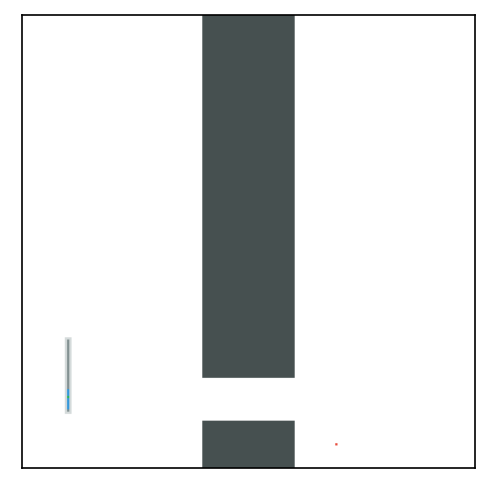

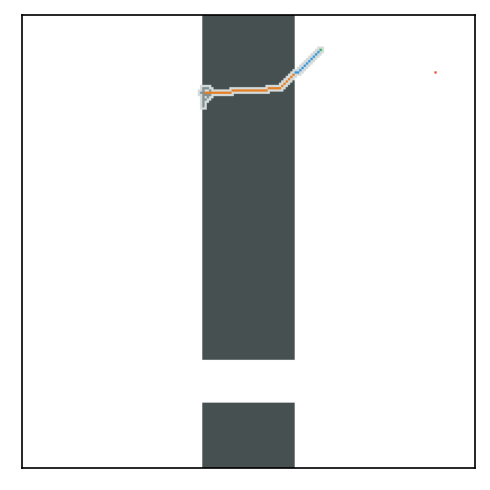

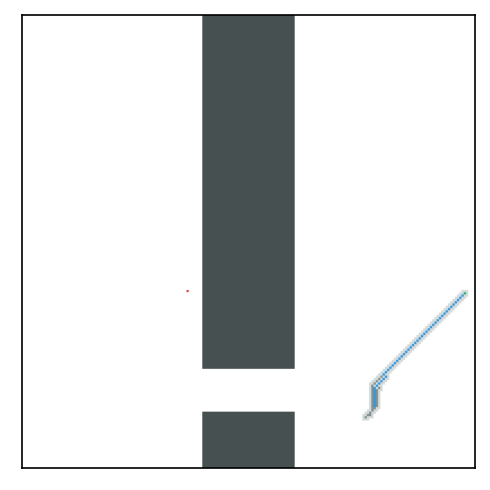

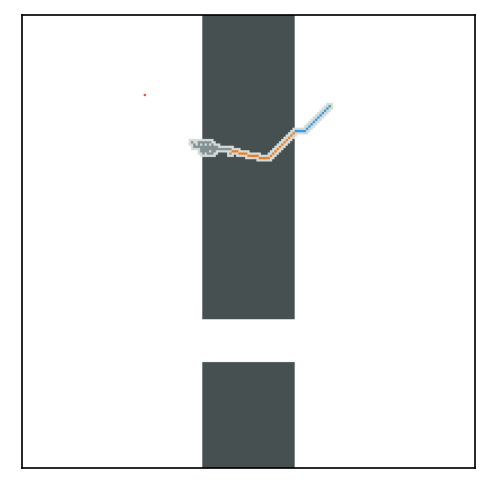

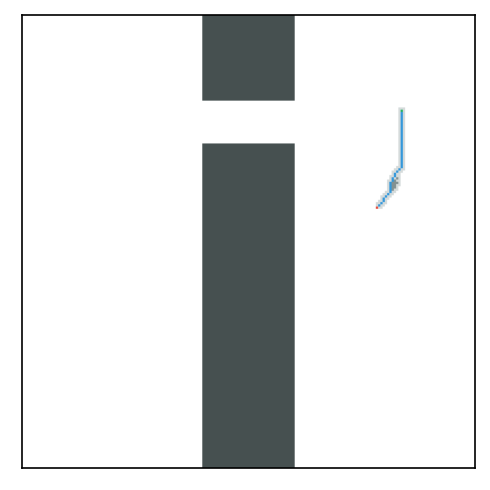

In [113]:
trainer.train(5, 10, 50, 1100, 0.7, 'alternating_gaps')

153
167
177
190
207
217
225
235
250
254
261



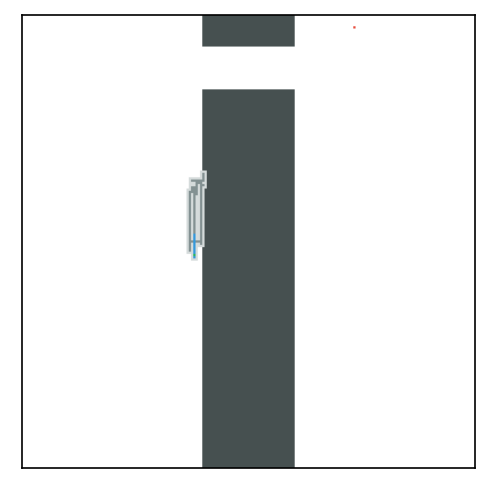

In [116]:
# то же, что simple_test
trainer.sampleMap(map_type='alternating_gaps')
trainer.sampleTargetPoints()
trainer.open = dict()
trainer.closed = dict()
trainer.invalid = set()
trainer.invalid.add( GridState(trainer.map.cells.shape[0],
                               trainer.map.cells.shape[1]) )
trainer.invalid.add( GridState(-1, -1) )
trainer.open[str(trainer.start)] = Node(trainer.start, g=0, depth=1)
for t in tqdm(range(1100)):
    node = trainer.mixPolicy(0)
    if t and t % 99 == 0:
        print(len(trainer.open))
    if node.state != trainer.goal:
        trainer.expand(node)
        trainer.closed[str(node)] = node
    else:
        break

path = MakePath(node)
Draw(trainer.map, trainer.start, trainer.goal, path[0], trainer.closed, trainer.open)

In [ ]:
torch.save(trainer.agent.state_dict(), '/content/drive/MyDrive/hs/gaps.pt')